# **Librerias**

In [1]:
# Importamos las Librerias 

import sklearn
import matplotlib
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, QuantileRegressor, ElasticNet

# Versiones 

print(f'Numpy Version: {np.__version__}')
print(f'CVXPY Version: {cp.__version__}')
print(f'Scikit-Learn Version: {sklearn.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')

Numpy Version: 2.3.1
CVXPY Version: 1.7.1
Scikit-Learn Version: 1.7.1
Matplotlib Version: 3.10.3


# **Utils**

In [2]:
# Funcion para Graficar la Funcion de Regresion Correspondiente y sus respectivos residuos

def plot_regression(ax, X, y, w_opt, b_opt, title):
    
    x_line = np.linspace(X.min(), X.max(), 100)
    y_line = w_opt*x_line + b_opt

    ax.scatter(X, y, color = 'black', label = 'Muestras')
    ax.plot(x_line, y_line, color = 'blue', label = 'Recta')

    for xi, yi in zip(X, y):
        y_pred = w_opt*xi + b_opt
        ax.plot([xi, xi], [yi, y_pred], color = 'red', linestyle = '--')

    ax.set_title(f'{title}\nPendiente = {w_opt:.4f}, Sesgo = {b_opt:.4f}')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel('y')
    ax.legend()

# **Comparativa**

In [3]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)

# Definimos las Distintas Regresiones

lambda_ridge = 2.0
lambda_lasso = 2.0
lambda_elastic_net = 2.0
rho_elastic_net = 0.5

def least_squares(residuals):

    loss = residuals**2    
    
    return loss 

def ridge_loss(residuals, weights):

    loss = residuals**2 + lambda_ridge * weights**2   
    
    return loss 

def lasso_loss(residuals, weights):

    loss = 0.5 * residuals**2 + lambda_lasso * abs(weights)   
    
    return loss 

def elastic_net_loss(residuals, weights):

    loss = residuals**2 + lambda_elastic_net * (rho_elastic_net * abs(weights) + ((1 - rho_elastic_net) / 2) * weights**2)  
    
    return loss 
    
def robust_l1_loss(residuals):

    loss = np.abs(residuals)
    
    return loss 

loss_functions = {"Minimos Cuadrados": lambda residuals, weights: least_squares(residuals), "Ridge": lambda residuals, weights: ridge_loss(residuals, weights),
                  "Lasso": lambda residuals, weights: lasso_loss(residuals, weights), "ElasticNet": lambda residuals, weights: elastic_net_loss(residuals, weights),
                  "Robusta L1": lambda residuals, weights: robust_l1_loss(residuals)}

# Visualizamos 

def plot_regressions(n_outliers=0):

    X_plot = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
    X_mod, y_mod = X.copy(), y.copy()
    
    idx_outliers = []
    if n_outliers > 0:
        idx_outliers = np.random.choice(len(y_mod), n_outliers, replace = False)
        y_mod[idx_outliers] += np.random.choice([-150, 150], size = n_outliers)
    

    models = {"Minimos Cuadrados": LinearRegression(), "Ridge": Ridge(alpha = lambda_ridge), "Lasso": Lasso(alpha = lambda_lasso), "ElasticNet": ElasticNet(alpha = lambda_elastic_net, l1_ratio = rho_elastic_net),
              "Robusta L1": QuantileRegressor(quantile = 0.5, alpha = 0)}
    
    fig, axs = plt.subplots(2, 3, figsize = (18,10))
    axs = axs.flatten()
    
    ax0 = axs[0]
    ax0.scatter(X_mod, y_mod, color = "black", label = "Muestras", alpha = 0.8)

    weights = {}
    residuals = {}
    y_preds = {}

    for name, model in models.items():
        model.fit(X_mod, y_mod)

        y_pred = model.predict(X_plot)
        y_train_pred = model.predict(X_mod)

        ax0.plot(X_plot, y_pred, linewidth = 2, label = f'{name}')

        weights[name] = model.coef_[0]
        residuals[name] = y_mod - model.predict(X_mod)
        y_preds[name] = y_train_pred
    
    ax0.set_title(f"Regresiones con {n_outliers} outliers")
    ax0.set_xlabel("X")
    ax0.set_ylabel("y")
    ax0.legend()
    ax0.grid(True)
    
    r_values = np.linspace(-200, 200, 400)
    for i, (name, model) in enumerate(models.items()):
        ax = axs[i+1]
        w = weights[name]
        losses = loss_functions[name](r_values, w)
        ax.plot(r_values, losses, label = name, color = 'blue', linewidth = 2)
        
        if len(idx_outliers) > 0:
            r_out = y_mod[idx_outliers] - model.predict(X_mod[idx_outliers])
            losses_out = loss_functions[name](r_out, w)
            ax.scatter(r_out, losses_out, s = 60, color = 'red', alpha = 0.7, label = 'Outliers')
        
        ax_hist = ax.twinx()
        hist_vals, bins = np.histogram(residuals[name], bins = 20)
        ax_hist.bar(0.5*(bins[:-1]+bins[1:]), hist_vals, width = bins[1]-bins[0], alpha = 0.6, color = 'gray', label = 'Residuos')
        ax_hist.set_ylim(0, hist_vals.max()*1.2)
        
        mse = np.mean((residuals[name])**2)

        ax.set_title(f"{name} pérdida MSE = {mse:.2f}")
        ax.set_xlabel("Residuos")
        ax.grid(True)
        ax.legend(loc = 'upper left')
    
    if len(axs) > len(models)+1:
        for ax in axs[len(models)+1:]:
            fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()

interact(plot_regressions, n_outliers=IntSlider(min = 0, max = 30, step = 1, value = 0))

interactive(children=(IntSlider(value=0, description='n_outliers', max=30), Output()), _dom_classes=('widget-i…

<function __main__.plot_regressions(n_outliers=0)>

# **Minimos Cuadrados**

Definimos la Funcion de Perdidas 

$$\begin{align*}
\text{minimizar}_w \quad & ||y - Xw||_2^2
\end{align*}$$

**Nota:** La definicion en Scikit-Learn es totalmente igual

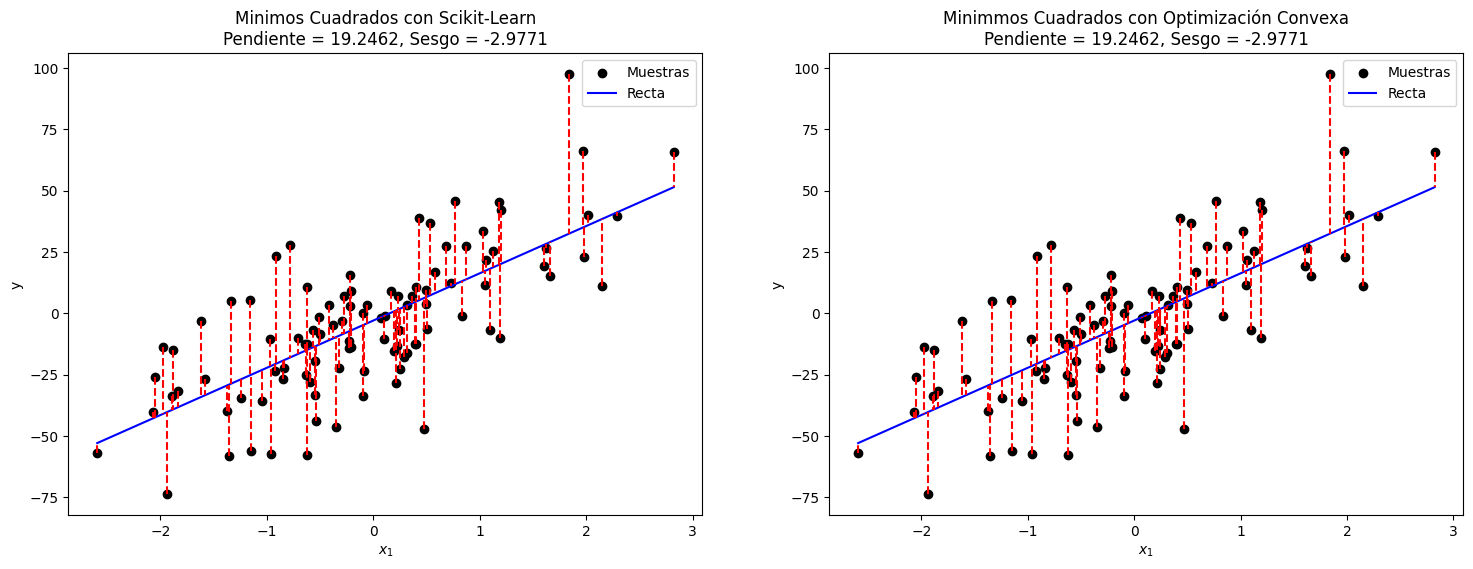

In [4]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)

# Definimos la Solucion mediante Sklearn (Obtenemos los parametros optimos)

model = LinearRegression() 

model.fit(X, y)

b_opt_skl = model.intercept_ 
m_opt_skl = model.coef_[0]

# Definimos la Solucion mediante Optimizacion Convexa 

X_flat = X.flatten()

X_with_bias = np.vstack([np.ones_like(X_flat), X_flat]).T

weights = cp.Variable(2)
objective = cp.Minimize(cp.sum_squares(y - X_with_bias @ weights))

problem = cp.Problem(objective)
problem.solve()

b_opt_conv = weights.value[0]
m_opt_conv = weights.value[1]

# Visualizamos 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,6))

plot_regression(ax1, X_flat, y, m_opt_skl, b_opt_skl, "Minimos Cuadrados con Scikit-Learn")
plot_regression(ax2, X_flat, y, m_opt_conv, b_opt_conv, "Minimmos Cuadrados con Optimización Convexa")

plt.show()

# **Ridge**

Definimos la Funcion de Perdidas 

$$\begin{align*}
\text{minimizar}_w \quad & ||y - Xw||_2^2 + \lambda ||w||_2^2 
\end{align*}$$

En donde 

$$\lambda = \frac{\sigma^2}{\tau^2}$$

* $\sigma^2$ grande, tenemos mas confianza en el **prior** ya que los datos son ruidosos 

* $\tau^2$ grande, tenemos mas confianza en el **likehood** ya que el prior es muy laxo 

* $\tau^2$ pequeño, tenemos mas confianza en el **prior** ya que el prior es muy restrictivo

**Nota:** La definicion en Scikit-Learn es totalmente igual

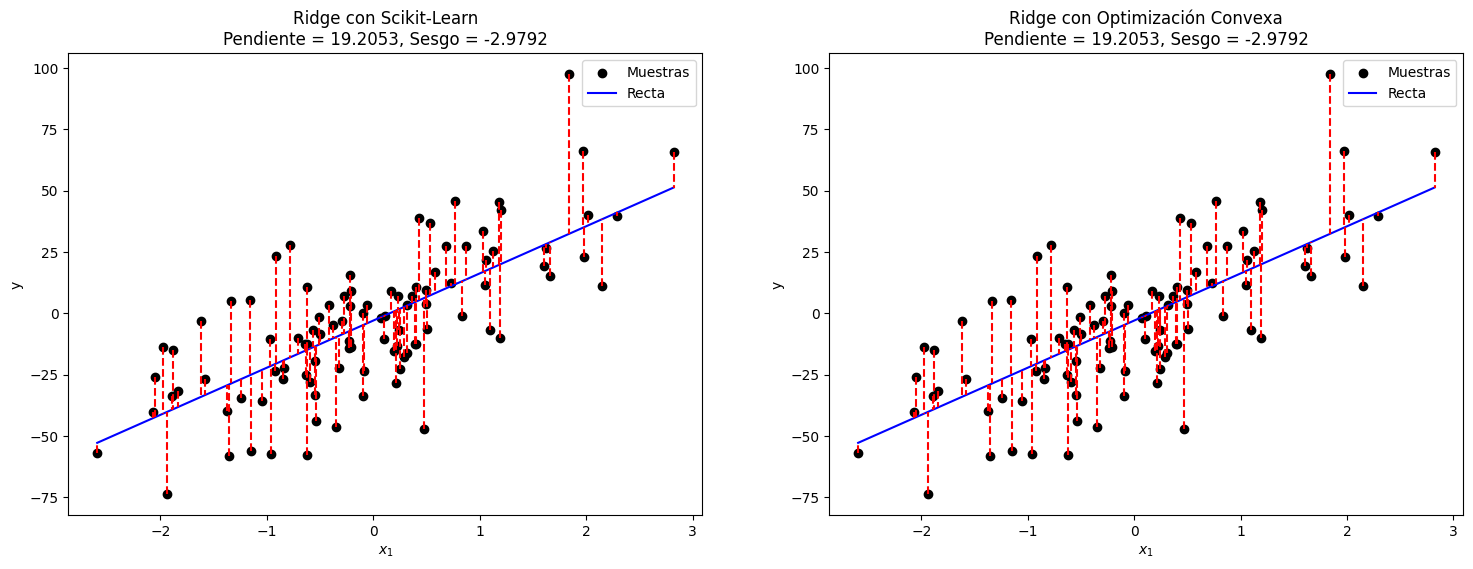

In [5]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)

# Definimos la Solucion mediante Sklearn (Obtenemos los parametros optimos) (alpha es nuestro parametro lambda)

model = Ridge(alpha = 0.25) 

model.fit(X, y)

b_opt_skl = model.intercept_ 
m_opt_skl = model.coef_[0]

# Definimos la Solucion mediante Optimizacion Convexa 

sigma2 = 1
tau2 = 4

X_flat = X.flatten()

X_with_bias = np.vstack([np.ones_like(X_flat), X_flat]).T

weights = cp.Variable(2)
objective = cp.Minimize(cp.sum_squares(y - X_with_bias @ weights) + (sigma2 / tau2) * weights[1]**2)

problem = cp.Problem(objective)
problem.solve()

b_opt_conv = weights.value[0]
m_opt_conv = weights.value[1]

# Visualizamos 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,6))

plot_regression(ax1, X_flat, y, m_opt_skl, b_opt_skl, "Ridge con Scikit-Learn")
plot_regression(ax2, X_flat, y, m_opt_conv, b_opt_conv, "Ridge con Optimización Convexa")

plt.show()

# **Lasso**

Definimos la Funcion de Perdidas 

$$\begin{align*}
\text{minimizar}_w \quad & \frac{1}{2} ||y - Xw||_2^2 + \lambda ||w||_1
\end{align*}$$

En donde 

$$\lambda = \frac{\sigma^2}{b}$$

* $\sigma^2$ grande, tenemos mas confianza en el **prior** ya que los datos son ruidosos 

* $b$ grande, tenemos mas confianza en el **likehood** ya que el prior es muy laxo 

* $b$ pequeño, tenemos mas confianza en el **prior** ya que el prior es muy restrictivo

En Scikit-Learn **normalizamos el error cuadratico** con respecto a la **cantidad de muestras del dataset**, esto nos ayuda a poder **comparar el efecto de $\lambda$** en datasets de diferentes tamaños

$$\begin{align*}
\text{minimizar}_w \quad & \frac{1}{2N} ||y - Xw||_2^2 + \lambda ||w||_1
\end{align*}$$



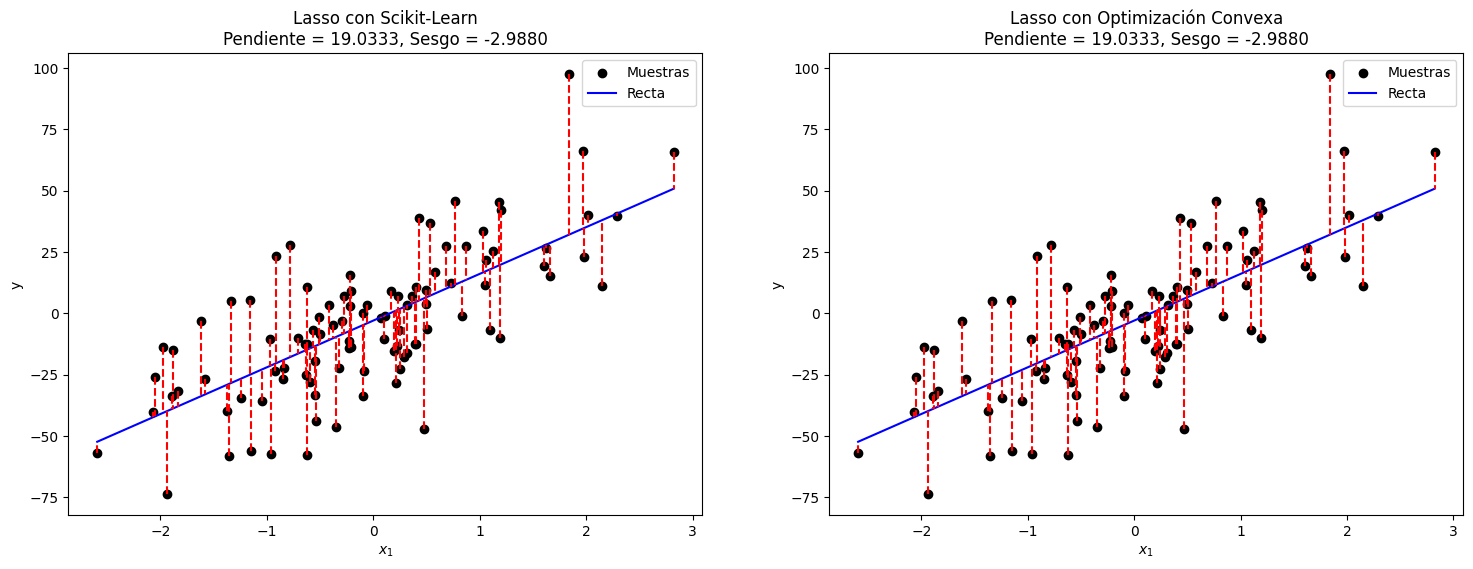

In [6]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)

# Definimos la Solucion mediante Sklearn (Obtenemos los parametros optimos) (alpha es nuestro parametro lambda)

model = Lasso(alpha = 0.25) 

model.fit(X, y)

b_opt_skl = model.intercept_ 
m_opt_skl = model.coef_[0]

# Definimos la Solucion mediante Optimizacion Convexa 

sigma2 = 1
b = 4

X_flat = X.flatten()

X_with_bias = np.vstack([np.ones_like(X_flat), X_flat]).T

weights = cp.Variable(2)
objective = cp.Minimize((1 / (2 * X.shape[0])) * cp.sum_squares(y - X_with_bias @ weights) + (sigma2 / b) * cp.abs(weights[1]))

problem = cp.Problem(objective)
problem.solve()

b_opt_conv = weights.value[0]
m_opt_conv = weights.value[1]

# Visualizamos 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,6))

plot_regression(ax1, X_flat, y, m_opt_skl, b_opt_skl, "Lasso con Scikit-Learn")
plot_regression(ax2, X_flat, y, m_opt_conv, b_opt_conv, "Lasso con Optimización Convexa")

plt.show()

# **Robusta L1**

Definimos la Funcion de Perdidas 

$$\begin{align*}
\text{minimizar}_w \quad & ||y - Xw||_1
\end{align*}$$

En Scikit-Learn se utiliza la funcion de perdidas **Pintball**, la cual si se aplica un valor quantile de $0.5$ y se elimina la regularizacion con $\lambda = 0$, la misma se reduce a la **funcion de perdidas L1**

$$\text{PB}_q(t) = q \max(t, 0) + (1 - q) \max(-t, 0) = \begin{cases} q \cdot t & \text{if } t > 0 \\ (q - 1) \cdot t & \text{if } t < 0 \end{cases}$$

$$\begin{align*}
\text{minimizar}_w \quad & \frac{1}{N} \sum_{i = 1}^N \text{PB}_q(y - Xw) + \lambda ||w||_1
\end{align*}$$

**Nota:** En Scikit-Learn **normalizamos el Pintball** con respecto a la **cantidad de muestras del dataset**, esto nos ayuda a poder **comparar el efecto de $\lambda$** en datasets de diferentes tamaños

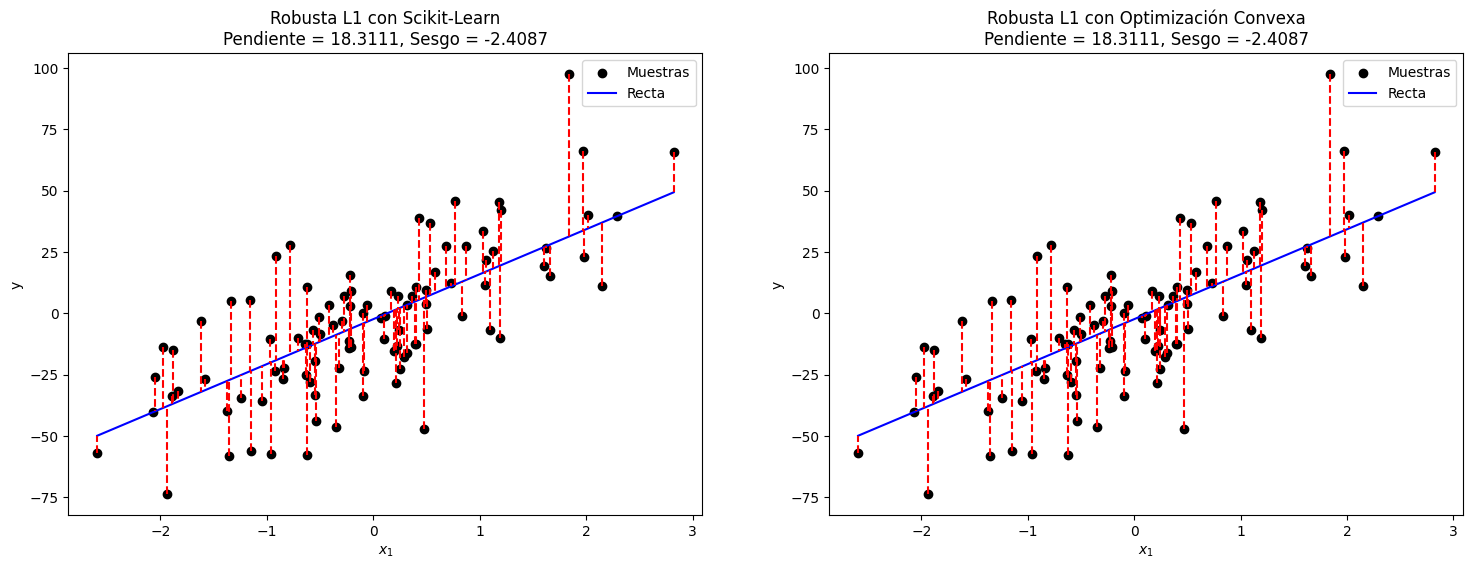

In [7]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)

# Definimos la Solucion mediante Sklearn (Quantile = 0.5 y alpha = 0 simulan la regresion robusta L1)

model = QuantileRegressor(quantile = 0.5, alpha = 0) 

model.fit(X, y)

b_opt_skl = model.intercept_ 
m_opt_skl = model.coef_[0]

# Definimos la Solucion mediante Optimizacion Convexa 

X_flat = X.flatten()

X_with_bias = np.vstack([np.ones_like(X_flat), X_flat]).T

weights = cp.Variable(2)
objective = cp.Minimize(cp.norm1(y - X_with_bias @ weights))

problem = cp.Problem(objective)
problem.solve()

b_opt_conv = weights.value[0]
m_opt_conv = weights.value[1]

# Visualizamos 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,6))

plot_regression(ax1, X_flat, y, m_opt_skl, b_opt_skl, "Robusta L1 con Scikit-Learn")
plot_regression(ax2, X_flat, y, m_opt_conv, b_opt_conv, "Robusta L1 con Optimización Convexa")

plt.show()

# **Elastic-Net**

Definimos la Funcion de Perdidas 

$$\begin{align*}
\text{minimizar}_w \quad & \frac{1}{2} ||y - Xw||_2^2 + \lambda \cdot \rho \cdot ||w||_1 + \frac{\alpha \cdot (1 - \rho)}{2} ||w||_2^2
\end{align*}$$

En donde 

$$\lambda = \frac{\sigma^2}{b}$$

$$\alpha = \frac{\sigma^2}{\tau^2}$$

* $\lambda$ Controla la regularizacion L1 

* $\alpha$ Controla la regularizacion L2 

* $\rho$ Es el parametro de que tanta importancia le damos a la regularizacion L1

En Scikit-Learn **normalizamos el error cuadratico** con respecto a la **cantidad de muestras del dataset**, esto nos ayuda a poder **comparar el efecto de $\lambda$** en datasets de diferentes tamaños

$$\begin{align*}
\text{minimizar}_w \quad & \frac{1}{2N} ||y - Xw||_2^2 + \lambda \left[\rho \cdot ||w||_1 + \frac{(1 - \rho)}{2} ||w||_2^2\right]
\end{align*}$$

Adicionalmente, en Scikit-Learn la regularización está controlada por un **único parámetro global** $\lambda$, mientras que la mezcla entre L1 y L2 se ajusta mediante $\rho$

**Nota:** Para $\rho = 1$ es lo mismo que regularizar solo con L1 (Lasso), en cambio cuando $\rho = 0$ solo regularizamos con L2 (Ridge), por ende el parametro $\rho$ los valores estan entre $[0, 1]$

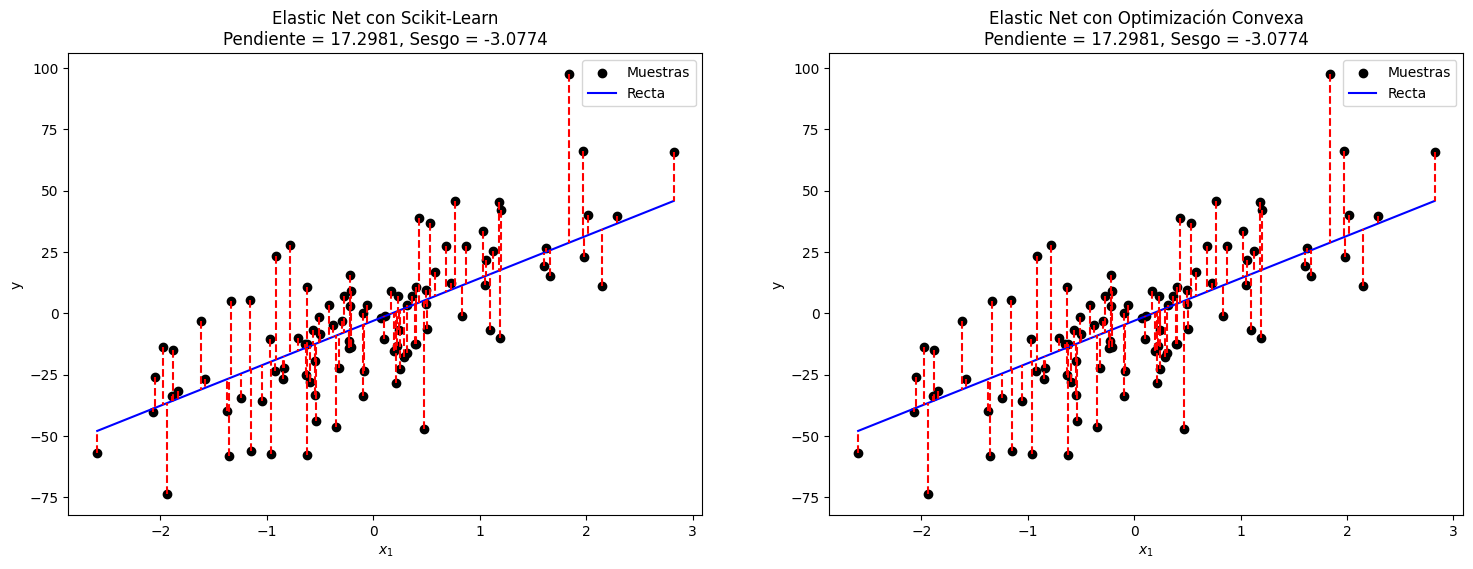

In [8]:
# Semilla

np.random.seed(25)

# Definimos el Dataset

X, y = make_regression(n_samples = 100, n_features = 1, noise = 20.0, random_state = 25)

# Definimos la Solucion mediante Sklearn (Quantile = 0.5 y alpha = 0 simulan la regresion robusta L1)

model = ElasticNet(alpha = 0.25, l1_ratio = 0.5) 

model.fit(X, y)

b_opt_skl = model.intercept_ 
m_opt_skl = model.coef_[0]

# Definimos la Solucion mediante Optimizacion Convexa 

sigma2 = 1
b = 4
tau2 = 4
rho = 0.5

X_flat = X.flatten()

X_with_bias = np.vstack([np.ones_like(X_flat), X_flat]).T

weights = cp.Variable(2)
objective = cp.Minimize((1 / (2 * X.shape[0])) * cp.sum_squares(y - X_with_bias @ weights) + (sigma2 / b) * rho *  cp.abs(weights[1]) + (((sigma2 / tau2) * (1 - rho)) / 2) * cp.sum_squares(weights[1]))

problem = cp.Problem(objective)
problem.solve()

b_opt_conv = weights.value[0]
m_opt_conv = weights.value[1]

# Visualizamos 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18,6))

plot_regression(ax1, X_flat, y, m_opt_skl, b_opt_skl, "Elastic Net con Scikit-Learn")
plot_regression(ax2, X_flat, y, m_opt_conv, b_opt_conv, "Elastic Net con Optimización Convexa")

plt.show()